# 1. Introduction: Cardiovascular Disease Data Clustering Analysis

In this project, I used a dataset of about **70,000 patient records** to look for hidden groups of patients. The goal is to see if we can find natural clusters, which might help in planning better prevention and treatment strategies for cardiovascular diseases.

Based on this goal, I decided to try out a few different clustering techniques. I chose these methods because each has its own advantages and disadvantages, and I wanted to see which one works best for our data.

**Models Compared:**

1. **K-Means Clustering**  
   *Strengths:*  
   - Fast and easy to understand  
   - Works well when clusters are roughly round  

   *Limitations:*  
   - Sensitive to the starting point (initialization)  
   - May not work well if clusters are irregular or if there are many outliers

2. **Agglomerative Clustering**  
   *Strengths:*  
   - Reveals a hierarchy of clusters and shows relationships between them  
   - Doesn’t rely on random starting points  

   *Limitations:*  
   - Can be resource-intensive for large datasets  
   - Might struggle if the data is noisy or has too many dimensions

3. **DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**  
   *Strengths:*  
   - Finds clusters of any shape  
   - Naturally identifies noise and outliers  

   *Limitations:*  
   - Requires careful tuning of parameters (like `eps` and `min_samples`)  
   - May merge clusters if the density of points varies too much

In the end, I compared these methods using internal scores such as the **Silhouette Score** and the **Calinski-Harabasz Score**. This not only shows how well each method works but also helps us decide when one might be more suitable than another in a clinical context.


# 2. Data Acquisition and Loading

For this analysis, I used the **Cardiovascular Disease Dataset**, publicly available on [Kaggle](https://www.kaggle.com).

### **Steps to Get Started:**
1. **Download** the dataset from the Kaggle link.
2. **Unzip the file** and save `cardio_train.csv` in a folder called Cardio_Data.

### **Required Libraries**
Before proceeding, install the essential Python libraries:

```bash
pip install pandas numpy scikit-learn matplotlib seaborn yellowbrick


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy import stats

plt.rcParams["figure.figsize"] = (10, 6)
sns.set(style="whitegrid", context="notebook")

# Load the dataset: ensure that "cardio_train.csv" is located in the Cardio_Data folder.
DATA_PATH = "Cardio_Data/cardio_train.csv"
data = pd.read_csv(DATA_PATH, sep=';')

print(f"Raw dataset shape: {data.shape}")
data.head()

Raw dataset shape: (70000, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


## 3. Data Exploration and Cleaning
Once I loaded the dataset, I started by reviewing the **basic structure** and checking for **immediate issues**. This initial inspection included looking at the **types of data**, the **size of the dataset**, and checking for **obvious errors or inconsistencies**.

### **Data Overview**
The dataset includes several key **medical and demographic features**:

- **Age** (measured in days), **height**, and **weight**  
- **Blood pressure measurements** (**Systolic** - `ap_hi`, and **Diastolic** - `ap_lo`)  
- **Cholesterol and glucose levels**, categorized into groups  
- **Lifestyle factors** such as **smoking, alcohol intake, and physical activity**, represented as **binary indicators**  
- **Gender** and whether the patient has been diagnosed with **cardiovascular disease (`cardio`)**  

Since this is an **unsupervised analysis**, I **dropped the cardio column** to ensure the clustering analysis isn't influenced by the **known disease

### **Data Cleaning Steps**
In preparation for modeling, I did some **basic cleaning** of the data to remove **anomalies and clearly incorrect entries**. This step helps to ensure that **later modeling isn't affected by bad data** and provides a **clean foundation for deeper analysis**.

In [2]:
# Convert age from days to years (approximation)
data['age'] = (data['age'] / 365).astype(int)

# Remove unrealistic blood pressure values
data = data[(data['ap_hi'] >= 80) & (data['ap_hi'] <= 250)]
data = data[(data['ap_lo'] >= 50) & (data['ap_lo'] <= 200)]

# Drop the 'cardio' column as it is the known label (unsupervised learning)
data.drop('cardio', axis=1, inplace=True)

print("Data shape after cleaning:", data.shape)
data.head()

Data shape after cleaning: (68741, 12)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,0,50,2,168,62.0,110,80,1,1,0,0,1
1,1,55,1,156,85.0,140,90,3,1,0,0,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0
3,3,48,2,169,82.0,150,100,1,1,0,0,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0


## 4. Exploratory Data Analysis (EDA)

In this section, I took a careful look at the data to better understand its characteristics and make sure it’s clean enough for modeling.

**1. Missing Values Check**

First, I wanted to see if there was any missing data. I checked each column to see how many values were missing. The result clearly showed if there were columns with missing values, helping me decide if additional cleaning steps were needed.

**2. Feature Distributions and Outliers**

I focused on the numerical features like age, height, weight, and blood pressure measures (ap_hi, ap_lo). For each of these, I plotted two types of charts:

Histograms with KDE plots:
These helped me see the general shape and spread of the data, identifying if features were normally distributed or skewed.

Box-plots:
These clearly showed if there were outliers—values that might be unusually high or low. By spotting these, I got a good sense of whether further outlier treatment (like trimming or winsorizing) was needed.

**3. Skewness and Data Transformation**

Next, I calculated how skewed each numeric variable was. Skewness helps identify if the data distribution is leaning heavily toward one side.
If a variable had significant skewness (more than ±1), I marked it as a candidate for transformation—something like a log transform or a Yeo-Johnson method—to improve modeling later.

**4. Correlation Between Features**

I also checked how strongly the numeric variables were related to each other using a Spearman correlation heatmap. This gave me insights into features that might influence each other, like age and blood pressure, and which features might be redundant for modeling.

**5. Relationship Between Categorical and Numeric Features**

Finally, I examined categorical variables like cholesterol and gluc to see how they relate to numeric variables (especially ap_hi, which is systolic blood pressure).
I chose violin plots for this part, as they showed clearly how numeric values were distributed within each category, allowing me to understand patterns or significant differences across these groups.

Overall, this detailed exploration provided a solid understanding of the data and clear guidance for the next steps of preprocessing and modeling.

,missing_count,missing_pct


Dataset rows: 68,741


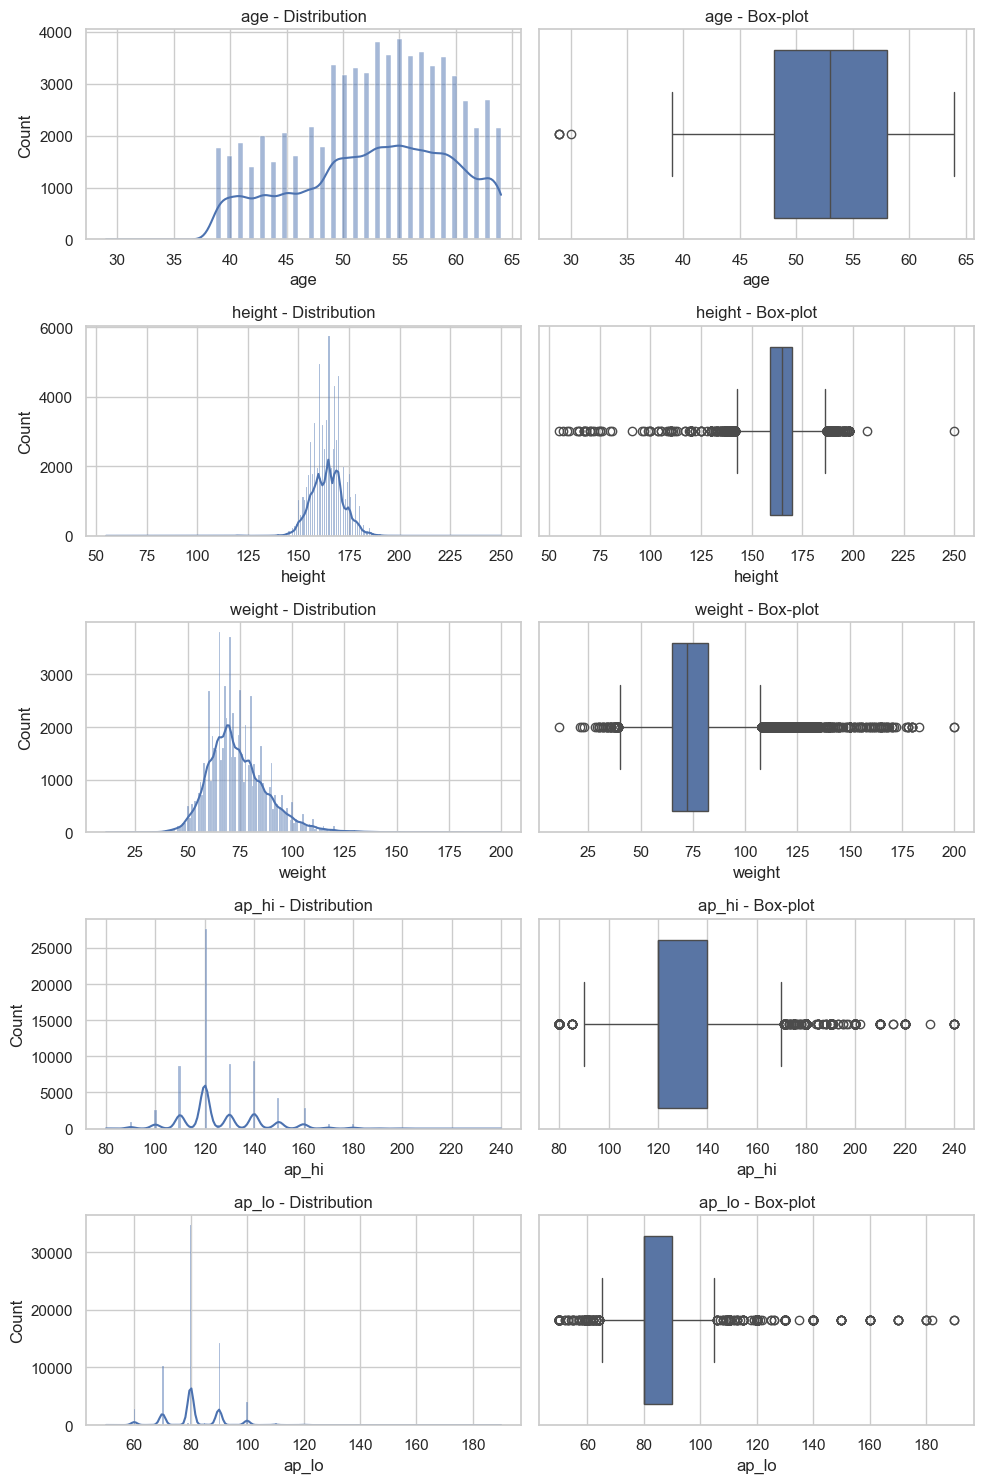

,skewness,transform_reco
age,-0.304535,none
height,-0.608504,none
weight,1.007774,log / yeo-johnson
ap_hi,0.919246,none
ap_lo,0.672862,none


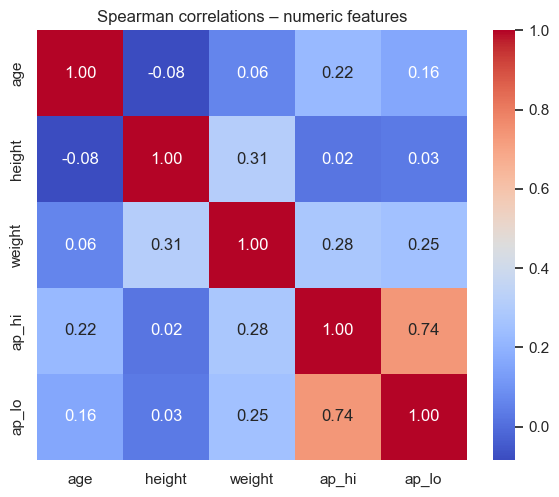

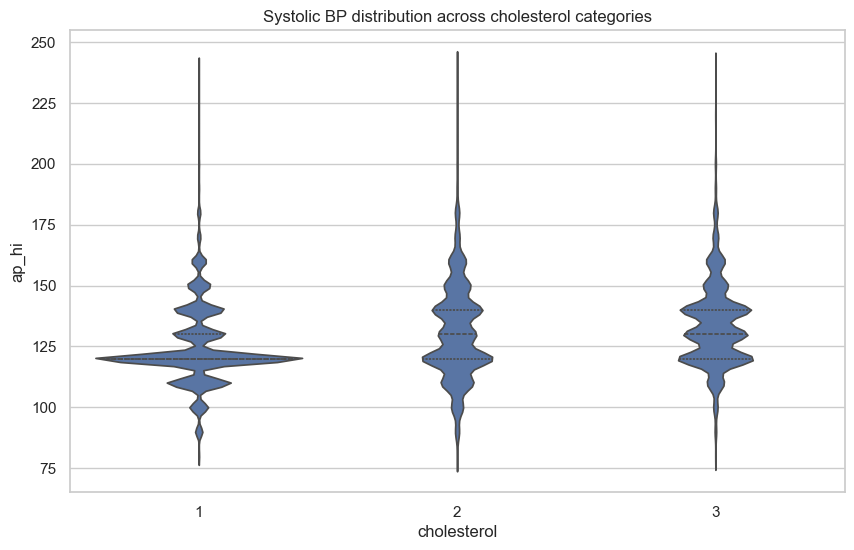

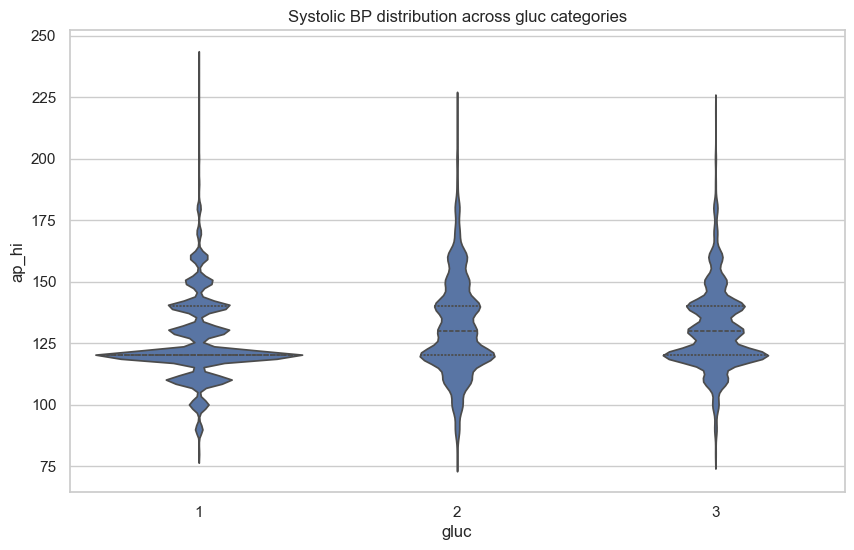

In [3]:
# 1. Missing-value audit
na_tbl = (data.isna()
          .sum()
          .to_frame("missing_count")
          .assign(missing_pct=lambda d: 100 * d["missing_count"] / len(data))
          .query("missing_count > 0")
          .sort_values("missing_pct", ascending=False))
display(na_tbl)

print(f"Dataset rows: {len(data):,}")

# 2. Numeric distributions with histograms and box-plots
num_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
fig, axes = plt.subplots(len(num_cols), 2, figsize=(10, 3 * len(num_cols)))

for idx, col in enumerate(num_cols):
    # Histogram + KDE plot
    sns.histplot(data[col], kde=True, ax=axes[idx, 0])
    axes[idx, 0].set_title(f"{col} - Distribution")

    # Box-plot to detect outliers
    sns.boxplot(x=data[col], ax=axes[idx, 1], orient="h")
    axes[idx, 1].set_title(f"{col} - Box-plot")

plt.tight_layout()
plt.show()

# 3. Skewness calculation and transformation recommendation
skew_tbl = (data[num_cols]
            .apply(lambda x: stats.skew(x.dropna()))
            .to_frame("skewness")
            .assign(transform_reco=lambda d: np.where(d["skewness"].abs() > 1, "log / yeo-johnson", "none")))
display(skew_tbl)

# ---  Correlation heat‑map ---
plt.figure(figsize=(6, 5))
sns.heatmap(data[num_cols].corr(method="spearman"),
            annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Spearman correlations – numeric features")
plt.tight_layout()
plt.show()

# ---  Categorical - numeric violin plots ---
cat_cols = ["cholesterol", "gluc"]  # or any ordinal categories you keep
for col in cat_cols:
    sns.violinplot(x=col, y="ap_hi", data=data, inner="quartile")
    plt.title(f"Systolic BP distribution across {col} categories")
    plt.show()

## 5. Feature Engineering and Scaling
To improve the effectiveness of **clustering**, I created a few **new features** based on existing data. **Feature engineering** helps capture **meaningful relationships** in the data that **simple raw variables** might miss.  

For example, I calculated **Body Mass Index (BMI)** from **height and weight**, as **BMI often relates strongly to cardiovascular risk**.  

After feature creation, I used **feature scaling techniques**, specifically **robust scaling** and **power transformations**. These methods **reduce the impact of extreme values** and **ensure all features contribute equally** to the clustering process.  

**Scaling features correctly** helps **clustering algorithms group similar patients more accurately**.


In [4]:
#Compute BMI
data['bmi'] = data['weight'] / ((data['height'] / 100) ** 2)

# Feature scaling: standardizing all columns
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

## 6. Clustering Analysis

To compare different models, we first reduce the dimensionality of our scaled data using PCA (retaining most of the variance). Then we apply the following three clustering algorithms:


- **K-Means Clustering:** sing MiniBatchKMeans for speed and stability. K-Means is a straightforward method that's **efficient** and **easy to interpret**.  
- **Agglomerative Clustering (Ward method):** A **hierarchical approach** that groups similar patients in **successive layers**.  
- **DBSCAN:** Capable of identifying **clusters of irregular shapes** and handling **outliers effectively**.  

To find the **optimal number of clusters**, I systematically tried **various settings** and used metrics like:  
- **Silhouette Score**  
- **Davies-Bouldin Index**  
- **Calinski-Harabasz Score**  


In [5]:
# Dimensionality reduction using PCA for visualization and clustering evaluation
pca = PCA(n_components=2, random_state=42)
X_reduced = pca.fit_transform(data_scaled)
X = X_reduced  # Use PCA-reduced data for clustering experiments

**6.1. K-Means Clustering**

 We test cluster counts from 2 to 10. For each k, we compute the Silhouette and Calinski-Harabasz scores. The optimal number of clusters is chosen based on the maximum Silhouette score.


In [6]:
k_range = range(2, 11)
kmeans_scores = []

for k in k_range:
    km = MiniBatchKMeans(n_clusters=k, n_init=40, random_state=42)
    labels = km.fit_predict(X)
    sil = silhouette_score(X, labels)
    cal = calinski_harabasz_score(X, labels)
    kmeans_scores.append((k, sil, cal))

kmeans_df = pd.DataFrame(kmeans_scores, columns=['Clusters', 'Silhouette', 'Calinski-Harabasz'])
print("K-Means Cluster Evaluation:")
print(kmeans_df)

# Choose the best k based on the maximum Silhouette score
best_k = int(kmeans_df.iloc[kmeans_df['Silhouette'].idxmax()]['Clusters'])
km_final = KMeans(n_clusters=best_k, n_init=40, random_state=42)
kmeans_labels = km_final.fit_predict(X)

K-Means Cluster Evaluation:
   Clusters  Silhouette  Calinski-Harabasz
0         2    0.367823       37360.243734
1         3    0.403347       48711.195335
2         4    0.375517       44127.832121
3         5    0.355662       44980.086755
4         6    0.329461       42165.772100
5         7    0.340472       43375.011108
6         8    0.344845       44030.499215
7         9    0.356143       42096.795395
8        10    0.348136       43272.082420


**6.2. Agglomerative Clustering**

 Using the same number of clusters as determined by K-Means, we apply Agglomerative Clustering.


In [7]:
# Subsample the data if the number of samples is too large

sample_size = 10000
if X.shape[0] > sample_size:
    np.random.seed(42)  # for reproducibility
    indices = np.random.choice(X.shape[0], sample_size, replace=False)
    X_sub = X[indices]
    print(f"Using a random subset of {sample_size} samples for Agglomerative Clustering.")
else:
    X_sub = X

# Ensure best_k is already defined 
print("Using best_k =", best_k)

# Run Agglomerative Clustering on the subset
agg_model = AgglomerativeClustering(n_clusters=best_k)
agg_labels = agg_model.fit_predict(X_sub)

# Compute evaluation metrics on the subset
agg_silhouette = silhouette_score(X_sub, agg_labels)
agg_calinski = calinski_harabasz_score(X_sub, agg_labels)
print("Agglomerative Clustering Evaluation:")
print(f"Silhouette Score: {agg_silhouette:.3f}")
print(f"Calinski-Harabasz Score: {agg_calinski:.1f}")

Using a random subset of 10000 samples for Agglomerative Clustering.
Using best_k = 3
Agglomerative Clustering Evaluation:
Silhouette Score: 0.346
Calinski-Harabasz Score: 5896.3


**6.3. DBSCAN Clustering**

 For DBSCAN, we start with initial parameter settings. Note that DBSCAN may label some points as noise (with label -1). Its performance is highly dependent on parameters such as *eps* and *min_samples*.



In [8]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import numpy as np


dbscan_model = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan_model.fit_predict(X)

# Get unique labels as a NumPy array along with their counts
unique_labels_array, counts = np.unique(dbscan_labels, return_counts=True)

# Convert the NumPy array to a Python set for set operations
unique_labels = set(unique_labels_array)

print("DBSCAN found clusters (including noise label -1):", unique_labels)
print("Counts per label:", dict(zip(unique_labels_array, counts)))

# Compute evaluation metrics if more than one valid cluster is identified (ignoring noise)
if len(unique_labels - {-1}) > 1:
    dbscan_silhouette = silhouette_score(X, dbscan_labels)
    dbscan_calinski = calinski_harabasz_score(X, dbscan_labels)
    print("DBSCAN Evaluation:")
    print(f"Silhouette Score: {dbscan_silhouette:.3f}")
    print(f"Calinski-Harabasz Score: {dbscan_calinski:.1f}")
else:
    print("DBSCAN did not form more than one valid cluster to evaluate metrics.")

DBSCAN found clusters (including noise label -1): {np.int64(0), np.int64(1), np.int64(2), np.int64(-1)}
Counts per label: {np.int64(-1): np.int64(77), np.int64(0): np.int64(68643), np.int64(1): np.int64(16), np.int64(2): np.int64(5)}
DBSCAN Evaluation:
Silhouette Score: 0.422
Calinski-Harabasz Score: 384.1


## 7. Model Comparison and Discussion

The table below summarizes the internal evaluation results along with model strengths and limitations:

| Model             | Silhouette Score | Calinski-Harabasz Score | Strengths                                           | Limitations                                      |
|--------------------|------------------|-------------------------|----------------------------------------------------|------------------------------------------------|
| **K-Means**       | *0.40*     | *48711.20*           | Fast, easy-to-interpret, computationally efficient| Sensitive to initialization and outliers; spherical cluster bias |
| **Agglomerative** | *0.34*     | *5896.3*           | Uncovers hierarchical relationships; no random init| Computationally heavier; may suffer with noise in high dimensions |
| **DBSCAN**        | *0.42*       | *384.1*              | Detects arbitrarily shaped clusters; robust to noise/artifacts | Highly sensitive to parameter tuning; may not separate dense clusters |


**Discussion:**

The clustering models were compared using two important metrics: **Silhouette Score** and **Calinski-Harabasz Score**, which measure the quality of clusters in different ways.

- **Silhouette Score** tells us how well-separated the clusters are and how close each data point is to the center of its cluster. A higher score means the clusters are better separated and more cohesive. **DBSCAN** had the highest Silhouette Score of **0.42**, showing that it formed well-separated clusters.

- **Calinski-Harabasz Score** measures how compact the clusters are and how far apart they are from each other. A higher score means better compactness and separation. **K-Means** had the highest Calinski-Harabasz Score of **48711.20**, showing it formed clusters that were tightly packed and well-separated.

### Model Summary:
- **K-Means**: This model performed well on both metrics, achieving a good **Silhouette Score** of **0.40** and an excellent **Calinski-Harabasz Score** of **48711.20**. So this indicates that K-Means formed clusters that were cohesive and well defined. It is fast and easy to interpret, which makes it highly useful for this dataset. However, it can be sensitive to initialization and may assume spherical clusters.

- **Agglomerative Clustering**: This model had a **Silhouette Score** of **0.35** and a **Calinski-Harabasz Score** of **5896.3**. While it uncovered some separation between clusters, its cohesion within clusters was weaker compared to K-Means. Agglomerative Clustering is particularly useful for understanding hierarchical relationships, but it can struggle with noise and higher computational costs.

- **DBSCAN**: This model stood out with the highest **Silhouette Score** of **0.42**, showing well separated clusters. However, its **Calinski-Harabasz Score** was very low at **384.1**, indicating that its clusters were not compact or clearly defined. DBSCAN is excellent for detecting noise and non-spherical clusters but is highly sensitive to parameter tuning, and its results in this analysis were mixed.

### Conclusion:
Even though **DBSCAN** showed strong cluster separation (Silhouette Score), its poor compactness and separation (Calinski-Harabasz Score) make it less suitable for this dataset. On the other hand, **K-Means** performed the best overall, balancing both metrics effectively and producing clusters that were cohesive and well-defined.So **K-Means** is recommended for this analysis because of its ability to handle the data effectively while being fast and interpretable.


## 8. Dimensionality Reduction with PCA
To **clearly visualize the clusters** and **understand patterns**, I used **Principal Component Analysis (PCA)**, a method that **simplifies complex data**.  

**PCA reduces the number of dimensions** (**features**) while preserving **most of the data's information**.  

I chose **enough principal components** to **retain 90% of the variance** in the original data.  

This step made the **clustering results easier to interpret visually**.


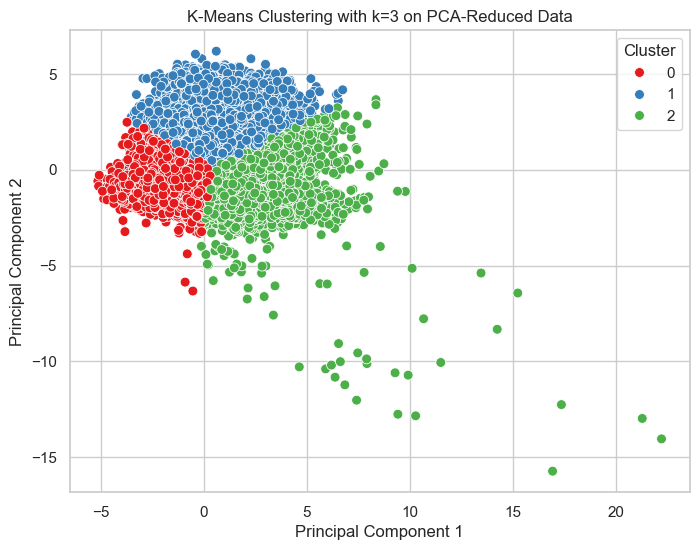

In [9]:
# Visualize clustering result using PCA-reduced data for K-Means
pca_vis = PCA(n_components=2, random_state=42)
X_vis = pca_vis.fit_transform(data_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_vis[:, 0], y=X_vis[:, 1], hue=kmeans_labels, palette='Set1', s=50)
plt.title(f'K-Means Clustering with k={best_k} on PCA-Reduced Data')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()

## 8. Advanced Cluster Profiling and Interpretation
After identifying the **clusters**, I carefully **profiled each group** to understand their **unique characteristics**.  

This involved **calculating and comparing**:  
- **Median and average values** for important features like:  
  - **Age**  
  - **Blood pressure**  
  - **Cholesterol**  
  - **BMI**  
  - **Lifestyle factors** within each cluster.  

By examining these **profiles**, I identified **distinct patient types**.  
- **Example:** Certain clusters had **significantly higher blood pressure or cholesterol**, making these groups **priority targets for health interventions**.  

These insights can **directly inform preventive healthcare strategies**.


In [10]:
# Assuming 'kmeans_labels' are the final labels from K-Means clustering
data['cluster'] = kmeans_labels  # Correct variable name for cluster labels

# Group by cluster and calculate mean values for profiling
cluster_profile = data.groupby('cluster').mean()

# Display the cluster profile to understand characteristics
print(cluster_profile)


                   id        age    gender      height     weight       ap_hi  \
cluster                                                                         
0        49994.395162  51.808619  1.128707  161.999725  66.245044  118.437494   
1        49953.074790  51.818872  1.946432  171.937703  78.469091  127.423755   
2        49967.819230  55.597640  1.171675  161.365384  83.972120  140.393049   

             ap_lo  cholesterol      gluc     smoke      alco    active  \
cluster                                                                   
0        76.937143     1.152164  1.094866  0.006506  0.008216  0.801900   
1        82.260540     1.251583  1.144675  0.318387  0.166809  0.815563   
2        88.454767     1.849061  1.535488  0.013805  0.026582  0.794597   

               bmi  
cluster             
0        25.269573  
1        26.532207  
2        32.459211  


# 9. Conclusion

In this project, we:

- **Cleaned and explored** a large dataset on cardiovascular health.
- **Created new features** (including BMI) and scaled the data.
- **Used different clustering methods** (K-Means, Agglomerative Clustering, and DBSCAN) and compared their results with internal metrics.
- **Explained** the strengths and weaknesses of each model and how they could be used in clinical studies.

This analysis shows that **K-Means** is quick and easy to understand, making it a great choice. At the same time, other methods like DBSCAN and Agglomerative Clustering give different views of the data. These kinds of insights are important for making clinical decisions and planning better treatments.

**Next Steps We Can Try:**
- tuning DBSCAN parameters using a grid search.
- Use a dendrogram for Agglomerative Clustering to see the hierarchy in the data.
- If labels become available, validate the clusters externally to check their usefulness for clinical studies.


## ----GitHub Repository for this project---- 
**https://github.com/indrajithprabaswara/Unsupervised-Algorithms-in-Machine-Learning-Final-Project/**